In [1]:
import pandas as pd
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
import gcsfs
from io import BytesIO
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.losses import Loss
from keras_tuner import RandomSearch

In [2]:
def resize_image(image_path, target_size=(224, 224)):
    try:
        with Image.open(image_path) as img:
            img_resized = img.resize(target_size)
            return img_resized
    except Exception as e:
        print(f"Error resizing {image_path}: {e}")
        return None

In [ ]:
target_size = (224, 224)
resized_images = []
for image_path in df['path']:
    resized_img = resize_image(image_path, target_size)
    if resized_img is not None:
        resized_images.append(resized_img)

In [11]:
output_dir = 'resized_images'
os.makedirs(output_dir, exist_ok=True)
for i, resized_img in enumerate(resized_images):
    img_name = f"resized_image_{i}.jpg"
    img_path = os.path.join(output_dir, img_name)
    resized_img.save(img_path)

In [4]:
path = []
filepath = '../resized_images/'
for root, dirs, files in os.walk(filepath):
    for file in files:
        path.append(os.path.join(root, file))

In [5]:
df = pd.DataFrame(path, columns=['resized_path'])

In [15]:
image = Image.open(df.resized_path[0])

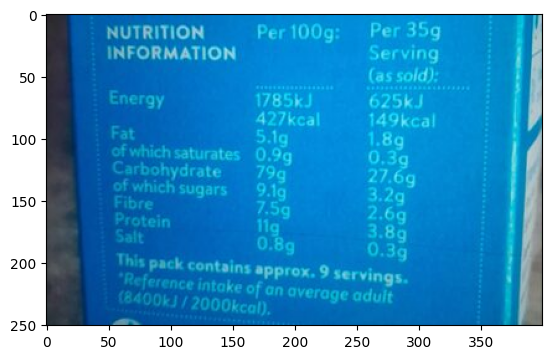

In [5]:
plt.imshow(image)
plt.show()

In [17]:
def get_image_shape(image_path):
    with Image.open(image_path) as img:
        return img.size
    
for i in range(0,5):
    image_path = df['resized_path'].iloc[i]
    image_shape = get_image_shape(image_path)
    print(f"Image {i+1} shape: {image_shape}")

Image 1 shape: (224, 224)
Image 2 shape: (224, 224)
Image 3 shape: (224, 224)
Image 4 shape: (224, 224)
Image 5 shape: (224, 224)


In [19]:
min_width = float('inf')
min_height = float('inf')

for image_path in df['resized_path']:
    try:
        width, height = get_image_shape(image_path)
        if width < min_width:
            min_width = width
        if height < min_height:
            min_height = height
    except Exception as e:
        print(f"Error processing {image_path}: {e}")

In [20]:
print(f"Minimum width: {min_width}")
print(f"Minimum height: {min_height}")

Minimum width: 224
Minimum height: 224


In [4]:
df = pd.read_csv('../csv/labeled_data.csv')

In [5]:
df.label[0]

'[{"x":10.44776119402985,"y":2.0522388059701493,"width":70.14925373134328,"height":78.54477611940298,"rotation":0,"rectanglelabels":["nutritional_table"],"original_width":224,"original_height":224}]'

In [6]:
df.count()

annotation_id    866
annotator        866
created_at       866
id               866
image            866
label            865
lead_time        866
updated_at       866
dtype: int64

In [7]:
df.dropna(inplace=True)

In [8]:
import json
data = {
    "path": [],
    "x": [],
    "y": [],
    "height": [],
    "width": []
}

for _, row in df.iterrows():
    path = row['image']
    labels = json.loads(row['label'])
    
    for label in labels:
        ow = label['original_width']
        oh = label['original_height']
        data['path'].append(path)
        x = label['x'] / 100.0 * ow
        y = label['y'] / 100.0 * oh
        w = label['width'] / 100.0 * ow
        h = label['height'] / 100.0 * oh
        data['x'].append(x)
        data['y'].append(y)
        data['height'].append(h)
        data['width'].append(w)


In [9]:
df = pd.DataFrame(data)

In [10]:
df.head()

,path,x,y,height,width
0,gs://nutritional-table-image-data/resized_imag...,23.402985,4.597015,175.940299,157.134328
1,gs://nutritional-table-image-data/resized_imag...,29.671642,0.417910,219.820896,174.686567
2,gs://nutritional-table-image-data/resized_imag...,21.731343,9.611940,206.029851,171.761194
3,gs://nutritional-table-image-data/resized_imag...,26.746269,9.194030,201.432836,173.850746
4,gs://nutritional-table-image-data/resized_imag...,18.388060,12.537313,155.880597,188.477612


In [11]:
df.isnull().sum()

path      0
x         0
y         0
height    0
width     0
dtype: int64

In [15]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=23011475)

In [16]:
train_df.reset_index(inplace=True)
train_df.head()

,index,path,x,y,height,width
0,670,gs://nutritional-table-image-data/resized_imag...,6.263648,7.456724,201.928096,207.296937
1,372,gs://nutritional-table-image-data/resized_imag...,22.966711,13.123835,200.138482,179.856192
2,30,gs://nutritional-table-image-data/resized_imag...,102.805970,24.238806,61.850746,83.164179
3,699,gs://nutritional-table-image-data/resized_imag...,6.263648,19.089214,178.663116,212.069241
4,314,gs://nutritional-table-image-data/resized_imag...,1.491345,136.607190,83.515313,107.973369


In [17]:
train_df.drop('index', axis=1, inplace=True)
train_df.head()

,path,x,y,height,width
0,gs://nutritional-table-image-data/resized_imag...,6.263648,7.456724,201.928096,207.296937
1,gs://nutritional-table-image-data/resized_imag...,22.966711,13.123835,200.138482,179.856192
2,gs://nutritional-table-image-data/resized_imag...,102.805970,24.238806,61.850746,83.164179
3,gs://nutritional-table-image-data/resized_imag...,6.263648,19.089214,178.663116,212.069241
4,gs://nutritional-table-image-data/resized_imag...,1.491345,136.607190,83.515313,107.973369


In [18]:
test_df.reset_index(inplace=True)
test_df.head()

,index,path,x,y,height,width
0,192,gs://nutritional-table-image-data/resized_imag...,4.175766,0.000000,205.507324,211.770972
1,742,gs://nutritional-table-image-data/resized_imag...,19.089214,0.596538,203.717710,187.312916
2,31,gs://nutritional-table-image-data/resized_imag...,5.014925,6.268657,172.179104,204.358209
3,747,gs://nutritional-table-image-data/resized_imag...,3.280959,5.368842,218.332889,218.631158
4,709,gs://nutritional-table-image-data/resized_imag...,35.195739,71.286285,91.270306,130.045273


In [19]:
test_df.drop('index', axis=1, inplace=True)
test_df.head()

,path,x,y,height,width
0,gs://nutritional-table-image-data/resized_imag...,4.175766,0.000000,205.507324,211.770972
1,gs://nutritional-table-image-data/resized_imag...,19.089214,0.596538,203.717710,187.312916
2,gs://nutritional-table-image-data/resized_imag...,5.014925,6.268657,172.179104,204.358209
3,gs://nutritional-table-image-data/resized_imag...,3.280959,5.368842,218.332889,218.631158
4,gs://nutritional-table-image-data/resized_imag...,35.195739,71.286285,91.270306,130.045273


In [20]:
train_df.to_csv('../csv/train.csv')
test_df.to_csv('../csv/test.csv')

In [12]:
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '../thesis-428619-ddafc8bc8aa4.json'

In [18]:
def load_and_preprocess_image(path):
    fs = gcsfs.GCSFileSystem(project='thesis-428619')
    path = path.replace("gs://", "")
    with fs.open(path, 'rb') as f:
        img_bytes = f.read()
        img = load_img(BytesIO(img_bytes), target_size=(224, 224))
        img_array = img_to_array(img)
        img_array = img_array / 255.0 
        return img_array

In [97]:
X_train = np.array([load_and_preprocess_image(path) for path in train_df['path']])
X_test = np.array([load_and_preprocess_image(path) for path in test_df['path']])

In [98]:
y_train = train_df[['x', 'y', 'height', 'width']].values
y_test = test_df[['x', 'y', 'height', 'width']].values

In [82]:
np.isnan(X_train).any()

False

In [83]:
np.isnan(X_test).any()

False

In [84]:
np.isnan(y_train).any()

False

In [85]:
np.isnan(y_test).any()

False

In [58]:
np.save('X_train.npy', X_train)
np.save('X_test.npy', X_test)
np.save('y_train.npy', y_train)
np.save('y_test.npy', y_test)

In [2]:
X_train = np.load('X_train.npy')
X_test = np.load('X_test.npy')
y_train = np.load('y_train.npy')
y_test = np.load('y_test.npy')

In [26]:
len(X_test)

174

In [27]:
len(y_test)

174

In [71]:
y_test[0]

array([  4.17576565,   0.        , 205.50732357, 211.77097204])

In [64]:
tf.random.set_seed(42)

In [34]:
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(224, 224, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(4)
])

In [35]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [37]:
early_stopping = EarlyStopping(monitor='val_loss', patience=1, restore_best_weights=True)

In [38]:
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/20
22/22 [==============================] - 32s 1s/step - loss: 4081.7371 - val_loss: 1709.2797
Epoch 2/20
22/22 [==============================] - 30s 1s/step - loss: 1954.1135 - val_loss: 1642.6906
Epoch 3/20
22/22 [==============================] - 30s 1s/step - loss: 1850.5216 - val_loss: 1514.9465
Epoch 4/20
22/22 [==============================] - 30s 1s/step - loss: 1730.7567 - val_loss: 1353.2899
Epoch 5/20
22/22 [==============================] - 30s 1s/step - loss: 1642.0815 - val_loss: 1338.3328
Epoch 6/20
22/22 [==============================] - 30s 1s/step - loss: 1501.3185 - val_loss: 1208.8342
Epoch 7/20
22/22 [==============================] - 30s 1s/step - loss: 1385.4153 - val_loss: 1177.3988
Epoch 8/20
22/22 [==============================] - 30s 1s/step - loss: 1281.5131 - val_loss: 1113.3185
Epoch 9/20
22/22 [==============================] - 30s 1s/step - loss: 1274.6055 - val_loss: 1186.5300


In [39]:
loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")

6/6 [==============================] - 2s 264ms/step - loss: 1113.3185
Test Loss: 1113.3184814453125


In [40]:
predictions = model.predict(X_test)

6/6 [==============================] - 2s 266ms/step


In [41]:
for i in range(5):
    print(f"{i}:True: {y_test[i]}, Predicted: {predictions[i]}")

0:True: [  4.17576565   0.         205.50732357 211.77097204], Predicted: [  7.449151  23.278696 165.53632  195.05133 ]
1:True: [ 19.08921438   0.59653795 203.71770972 187.31291611], Predicted: [ 22.769297  37.423004 145.27335  164.68484 ]
2:True: [  5.01492537   6.26865672 172.17910448 204.35820896], Predicted: [ 23.99651  47.27347 136.71835 172.39584]
3:True: [  3.28095872   5.36884154 218.33288948 218.63115846], Predicted: [  6.1859403  16.601227  201.15115   220.6487   ]
4:True: [ 35.19573901  71.28628495  91.27030626 130.04527297], Predicted: [ 17.825708  34.71018  134.78639  196.21431 ]


In [30]:
def display_image_with_bbox(image, bbox):
    plt.figure(figsize=(8, 6))
    plt.imshow(image)
    plt.gca().add_patch(plt.Rectangle((bbox[0], bbox[1]), bbox[3], bbox[2], 
                                      linewidth=2, edgecolor='r', facecolor='none'))
    plt.axis('off')
    plt.show()

In [31]:
def load_and_preprocess_testimage(path, target_size=(224, 224)):
    fs = gcsfs.GCSFileSystem(project='thesis-428619')
    path = path.replace("gs://", "")
    with fs.open(path, 'rb') as f:
        img_bytes = f.read()
        img = load_img(BytesIO(img_bytes), target_size=target_size)
        img_array = img_to_array(img)
        img_array = img_array / 255.0  
        return img, img_array

In [33]:
img,img_array = load_and_preprocess_testimage(test_df.path[1])

In [49]:
actual_bounding_box = [test_df.x[1], test_df.y[1], test_df.height[1], test_df.width[1]]

In [52]:
model.save('models/basic_model.h5')

In [32]:
class IoULoss(Loss):
    def call(self, y_true, y_pred):
        xA = tf.maximum(y_true[..., 0], y_pred[..., 0])
        yA = tf.maximum(y_true[..., 1] - y_true[..., 3], y_pred[..., 1] - y_pred[..., 3])
        xB = tf.minimum(y_true[..., 0] + y_true[..., 2], y_pred[..., 0] + y_pred[..., 2])
        yB = tf.minimum(y_true[..., 1], y_pred[..., 1])

        interArea = tf.maximum(0.0, xB - xA) * tf.maximum(0.0, yB - yA)
        boxAArea = y_true[..., 2] * y_true[..., 3]
        boxBArea = y_pred[..., 2] * y_pred[..., 3]

        iou = interArea / (boxAArea + boxBArea - interArea)
        return 1 - iou

In [53]:
def build_model(hp):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=(224, 224, 3)))
    for i in range(hp.Int('conv_layers', 1, 3)):
        model.add(tf.keras.layers.Conv2D(
            filters=hp.Int('filters_' + str(i), min_value=32, max_value=128, step=32),
            kernel_size=(3, 3),
            activation='relu'
        ))
        model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(
        units=hp.Int('dense_units', min_value=128, max_value=512, step=64),
        activation='relu'
    ))
    model.add(tf.keras.layers.Dense(4, activation=hp.Choice('final_activation', values=['linear', 'relu'])))
    hp_optimizer = hp.Choice('optimizer', values=['adam', 'sgd', 'rmsprop'])
    if hp_optimizer == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=hp.Float('lr', 1e-4, 1e-2, sampling='log'))
    elif hp_optimizer == 'sgd':
        optimizer = tf.keras.optimizers.SGD(learning_rate=hp.Float('lr', 1e-4, 1e-2, sampling='log'))
    elif hp_optimizer == 'rmsprop':
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=hp.Float('lr', 1e-4, 1e-2, sampling='log'))

    model.compile(optimizer=optimizer, loss=IoULoss())
    
    return model

In [55]:
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=20,
    executions_per_trial=1,
    directory='my_dir',
    project_name='hyperparam_tuning'
)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [56]:
tuner.search(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[early_stopping])

Trial 20 Complete [00h 06m 43s]
val_loss: 1.0

Best val_loss So Far: 0.4367460310459137
Total elapsed time: 01h 32m 10s


In [60]:
best_model = tuner.get_best_models(num_models=1)[0]

In [61]:
best_model.save('models/tuned_model.h5')

In [68]:
def build_model(hp):
    input_shape = (224, 224, 3)
    backbone = ResNet50(input_shape=input_shape, include_top=False, weights='imagenet')
    x = Flatten()(backbone.output)
    x = Dense(hp.Int('dense_units', min_value=512, max_value=2048, step=512), activation='relu')(x)
    bbox_regression = Dense(4)(x)
    model = Model(inputs=backbone.input, outputs=bbox_regression)
    hp_optimizer = hp.Choice('optimizer', values=['adam', 'rmsprop'])
    if hp_optimizer == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=hp.Float('lr', 1e-4, 1e-2, sampling='log'))
    elif hp_optimizer == 'rmsprop':
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=hp.Float('lr', 1e-4, 1e-2, sampling='log'))
    
    model.compile(optimizer=optimizer, loss=IoULoss())
    return model

In [69]:
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=20,
    executions_per_trial=1,
    directory='my_dir',
    project_name='hyperparam_tuning_rcnn'
)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

Reloading Tuner from my_dir\hyperparam_tuning_rcnn\tuner0.json


In [70]:
tuner.search(
    X_train, 
    y_train, 
    epochs=100,  
    batch_size=8, 
    validation_split=0.2,
    callbacks=[early_stopping]
)

Trial 20 Complete [00h 00m 03s]

Best val_loss So Far: 0.32800406217575073
Total elapsed time: 15h 34m 30s


In [71]:
resnet_best_model = tuner.get_best_models(num_models=1)[0]

In [73]:
resnet_best_model.save('models/resnet_tuned_model.h5')

In [13]:
def calculate_area_ratio(row):
    fs = gcsfs.GCSFileSystem(project='thesis-428619')
    with fs.open(row['path'], 'rb') as f:
        image = Image.open(f)
        img_width, img_height = image.size
    bbox_area = row['width'] * row['height']
    img_area = img_width * img_height
    return bbox_area / img_area

In [14]:
df['area_ratio'] = df.apply(calculate_area_ratio, axis=1)

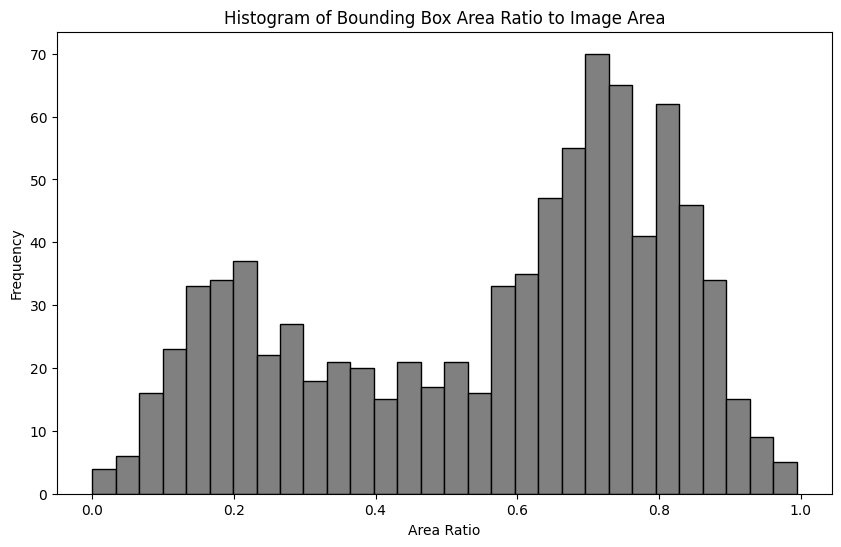

In [18]:
plt.figure(figsize=(10, 6))
plt.hist(df['area_ratio'], bins=30, color='grey', edgecolor='black')
plt.title('Histogram of Bounding Box Area Ratio to Image Area')
plt.xlabel('Area Ratio')
plt.ylabel('Frequency')
plt.show()